In [1]:
import pandas as pd
from anomaly_detection import detect_anomaly, loader
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import GroupShuffleSplit
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from pylab import *
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

In [2]:
dir(detect_anomaly)

['AutoDiagonalNormal',
 'DataLoader',
 'IsolationForest',
 'KMeans',
 'Model',
 'NeuralNetwork',
 'NeuralNetwork2L',
 'OneClassSVM',
 'Predictive',
 'PyroModule',
 'PyroSample',
 'SVI',
 'ToTensor',
 'Trace_ELBO',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'dist',
 'mixture',
 'nn',
 'np',
 'optimizeBNN',
 'optimizeNN',
 'partial',
 'pyro',
 'runGaussianMixture',
 'runIsolationForest',
 'runKMeans',
 'runOneClassSVM',
 'torch',
 'tqdm',
 'trange']

In [3]:
# !pip install git+https://github.com/kpapdac/anomaly_detection.git

In [4]:
donors = pd.read_csv(r'https://github.com/GuansongPang/ADRepository-Anomaly-detection-datasets/raw/main/numerical%20data/DevNet%20datasets/KDD2014_donors_10feat_nomissing_normalised.csv').iloc[0:10000,:]

The donors data is taken from KDD Cup 2014 for predicting excitement of projects proposed by K-12 school teachers, in which
exceptionally exciting projects are used as anomalies (5.92% data).

In [5]:
donors.groupby('class')['fully_funded=t'].count()

class
0    9385
1     615
Name: fully_funded=t, dtype: int64

In [6]:
donors.nunique()

at_least_1_teacher_referred_donor=t                  3
fully_funded=t                                       2
at_least_1_green_donation=0                          3
great_chat=t                                         2
three_or_more_non_teacher_referred_donors=0          3
one_non_teacher_referred_donor_giving_100_plus=t     3
donation_from_thoughtful_donor=t                     3
great_messages_proportion                           96
teacher_referred_count                              28
non_teacher_referred_count                          59
class                                                2
dtype: int64

In [7]:
disc=4 # Disc(retization) may be between 2 and 9
r=np.array(range(disc+1))/(1.0*disc)
print(r)
# quantiles are building using pandas.qcut
# The "class" column is just copied.
l=[]
for col in donors.columns.values:
    if col in ['great_messages_proportion','non_teacher_referred_count']:
        l.append(pd.DataFrame(pd.qcut(donors[col],r),columns=[col]))
    else:
        l.append(pd.DataFrame(donors[col].astype(int),columns=[col]))
treated=pd.concat(l, join='outer', axis=1)

treated.head()

[0.   0.25 0.5  0.75 1.  ]


,at_least_1_teacher_referred_donor=t,fully_funded=t,at_least_1_green_donation=0,great_chat=t,three_or_more_non_teacher_referred_donors=0,one_non_teacher_referred_donor_giving_100_plus=t,donation_from_thoughtful_donor=t,great_messages_proportion,teacher_referred_count,non_teacher_referred_count,class
0,0,1,1,0,1,1,0,"(-0.001, 0.4]",0,"(-0.001, 0.00658]",0
1,1,1,0,0,0,0,0,"(0.4, 0.529]",0,"(0.0143, 0.306]",0
2,0,1,1,0,1,1,0,"(-0.001, 0.4]",0,"(-0.001, 0.00658]",0
3,0,0,1,0,1,1,0,"(0.4, 0.529]",0,"(-0.001, 0.00658]",0
4,0,1,0,0,1,1,0,"(0.4, 0.529]",0,"(-0.001, 0.00658]",0


Learned in 24.406406ms


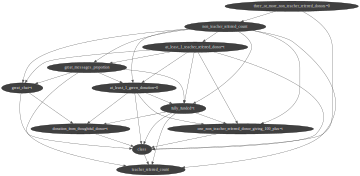

In [8]:
#we put the discretized values in a csv file in order to be learned by pyAgrum
treated.to_csv("donors_bn.csv",index=False)

learner=gum.BNLearner("donors_bn.csv")
learner.useLocalSearchWithTabuList()
bn_donors=learner.learnBN()
print("Learned in {0}ms".format(1000*learner.currentTime()))
gnb.showBN(bn_donors)

In [9]:
bn_donors.cpt('class')

(pyAgrum.Potential<double>@0x55cb337e9ef0) 
                                                ||  class            |
three_|at_lea|great_|at_lea|donati|one_no|fully_||0        |1        |
------|------|------|------|------|------|------||---------|---------|
0     |0     |0     |0     |0     |0     |0     || 1.0000  | 0.0000  |
1     |0     |0     |0     |0     |0     |0     || 1.0000  | 0.0000  |
0     |1     |0     |0     |0     |0     |0     || 0.9998  | 0.0002  |
1     |1     |0     |0     |0     |0     |0     || 0.9999  | 0.0001  |
0     |0     |1     |0     |0     |0     |0     || 1.0000  | 0.0000  |
1     |0     |1     |0     |0     |0     |0     || 1.0000  | 0.0000  |
[...116 more line(s) ...]
0     |1     |0     |1     |1     |1     |1     || 0.5000  | 0.5000  |
1     |1     |0     |1     |1     |1     |1     || 0.5000  | 0.5000  |
0     |0     |1     |1     |1     |1     |1     || 0.5000  | 0.5000  |
1     |0     |1     |1     |1     |1     |1     || 0.9987  | 0.0013  |
0     |1     |1     |1     |1     |1     |1     || 0.5000  | 0.5000  |
1     |1     |1     |1     |1     |1     |1     || 0.5000  | 0.5000  |

In [10]:
bn_donors.cpt('fully_funded=t')

(pyAgrum.Potential<double>@0x55cb33f92460) 
                           ||  fully_funded=t   |
at_lea|non_te|at_lea|great_||0        |1        |
------|------|------|------||---------|---------|
0     |(-0.00|0     |(-0.00|| 0.2054  | 0.7946  |
1     |(-0.00|0     |(-0.00|| 0.1425  | 0.8575  |
0     |(0.006|0     |(-0.00|| 0.0632  | 0.9368  |
1     |(0.006|0     |(-0.00|| 0.1883  | 0.8117  |
0     |(0.009|0     |(-0.00|| 0.0469  | 0.9531  |
1     |(0.009|0     |(-0.00|| 0.1002  | 0.8998  |
[...52 more line(s) ...]
0     |(0.006|1     |(0.66,|| 0.1775  | 0.8225  |
1     |(0.006|1     |(0.66,|| 0.5000  | 0.5000  |
0     |(0.009|1     |(0.66,|| 0.0960  | 0.9040  |
1     |(0.009|1     |(0.66,|| 0.0077  | 0.9923  |
0     |(0.014|1     |(0.66,|| 0.0750  | 0.9250  |
1     |(0.014|1     |(0.66,|| 0.2505  | 0.7495  |

In [11]:
ie=gum.LazyPropagation(bn_donors)
ie.setEvidence({'great_messages_proportion': '(0.66, 1.0]'})
ie.makeInference()
ie.posterior("class")

(pyAgrum.Potential<double>@0x55cb33fa8360) 
  class            |
0        |1        |
---------|---------|
 0.8196  | 0.1804  |

In [12]:
bn_donors.parents('class')

{0, 1, 2, 3, 4, 5, 6}

In [13]:
parents = treated.iloc[:,list(bn_donors.parents('class'))].columns
print(parents)

Index(['at_least_1_teacher_referred_donor=t', 'fully_funded=t',
       'at_least_1_green_donation=0', 'great_chat=t',
       'three_or_more_non_teacher_referred_donors=0',
       'one_non_teacher_referred_donor_giving_100_plus=t',
       'donation_from_thoughtful_donor=t'],
      dtype='object')


Sample stratification

In [14]:
donors

,at_least_1_teacher_referred_donor=t,fully_funded=t,at_least_1_green_donation=0,great_chat=t,three_or_more_non_teacher_referred_donors=0,one_non_teacher_referred_donor_giving_100_plus=t,donation_from_thoughtful_donor=t,great_messages_proportion,teacher_referred_count,non_teacher_referred_count,class
0,0.00000,1,1.000000,0,1.000000,1.000000,0.000000,0.000000,0.000000,0.003289,0
1,1.00000,1,0.000000,0,0.000000,0.000000,0.000000,0.500000,0.026490,0.029605,0
2,0.00000,1,1.000000,0,1.000000,1.000000,0.000000,0.000000,0.000000,0.003289,0
3,0.00000,0,1.000000,0,1.000000,1.000000,0.000000,0.529271,0.000000,0.006579,0
4,0.00000,1,0.000000,0,1.000000,1.000000,0.000000,0.529271,0.000000,0.003289,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.00000,0,0.000000,1,0.000000,0.000000,0.000000,0.660000,0.000000,0.009868,0
9996,0.00000,0,0.000000,1,1.000000,1.000000,0.000000,1.000000,0.000000,0.003289,0
9997,0.23748,0,0.278581,0,0.481114,0.719735,0.013213,0.529271,0.005148,0.014346,0
9998,0.23748,0,0.278581,0,0.481114,0.719735,0.013213,0.529271,0.005148,0.014346,0


In [25]:
X = donors.iloc[0:5000,list(bn_donors.parents('class'))].copy().to_numpy()
y = donors.iloc[0:5000,donors.shape[1]-1:donors.shape[1]].copy().to_numpy()
groups = donors.iloc[0:5000,donors.shape[1]-1:donors.shape[1]].copy().to_numpy()
gss = GroupShuffleSplit(n_splits=2, train_size=1, random_state=42)
X_train_twoclass = []
y_train_twoclass = []
for i, (train_index, test_index) in enumerate(gss.split(X, y,groups)):
    print(f"Fold {i}:")
    print(len(groups[train_index]))
    X_train = X[train_index]
    y_train = y[train_index]
    X_train_twoclass.append(X_train)
    y_train_twoclass.append(y_train)
print(np.concatenate([X_train_twoclass[0],X_train_twoclass[1]]).shape)
X_train_m = np.concatenate([X_train_twoclass[0],X_train_twoclass[1]])
y_train_m = np.concatenate([y_train_twoclass[0],y_train_twoclass[1]])

Fold 0:
4694
Fold 1:
306
(5000, 7)


OneClassSVM, Isolation Forest, Kmeans, Gaussian MM

In [17]:
X = X_train_m.copy()
pred_svm = detect_anomaly.runOneClassSVM().fit_predict(X,X)
pred_if = detect_anomaly.runIsolationForest().fit_predict(X,X)
pred_km = detect_anomaly.runKMeans(2).fit_predict(X,X)
pred_gmm = detect_anomaly.runGaussianMixture(2).fit_predict(X,X)

In [18]:
(pred_svm==1).sum(),(pred_svm==-1).sum(), (pred_if==1).sum(),(pred_if==-1).sum(), (pred_km==1).sum(),(pred_km==0).sum(), (pred_gmm[0]==1).sum(),(pred_gmm[0]==0).sum()

(2358, 2642, 1884, 3116, 2359, 2641, 3248, 1752)

Deep Learning

In [26]:
nn_model = detect_anomaly.NeuralNetwork(D_in=X.shape[1],H=2)
x = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y[:,0])
# x = torch.randn(128, 20)
# y = torch.from_numpy(np.repeat(0,128))
X_y = [(x[i],y[i]) for i in range(len(x))]
dataset_ = loader.FeatureClusterDataset(X_y)
train_dataloader = DataLoader(dataset_, batch_size=64)
opt = detect_anomaly.optimizeNN(train_dataloader, nn_model, learning_rate=0.05, batch_size=64, epochs=5)
opt.train_loop()
opt.iterate()

tensor([-0.3038, -0.6757], grad_fn=<SliceBackward0>)
loss: 0.618778  [   64/ 5000]
tensor([ 0.1776, -0.7177], grad_fn=<SliceBackward0>)
tensor([ 0.1327, -0.5770], grad_fn=<SliceBackward0>)
tensor([ 0.1974, -1.1839], grad_fn=<SliceBackward0>)
tensor([ 0.2761, -0.8922], grad_fn=<SliceBackward0>)
tensor([ 0.2267, -0.6710], grad_fn=<SliceBackward0>)
tensor([0.0378, 0.0165], grad_fn=<SliceBackward0>)
tensor([ 0.2660, -0.6917], grad_fn=<SliceBackward0>)
tensor([-0.0738, -0.7243], grad_fn=<SliceBackward0>)
tensor([0.0017, 0.0170], grad_fn=<SliceBackward0>)
tensor([ 0.1888, -0.4331], grad_fn=<SliceBackward0>)
tensor([-0.0386, -0.4610], grad_fn=<SliceBackward0>)
tensor([ 0.5423, -0.6401], grad_fn=<SliceBackward0>)
tensor([ 0.3929, -0.6016], grad_fn=<SliceBackward0>)
tensor([ 0.2980, -0.5423], grad_fn=<SliceBackward0>)
tensor([ 0.7145, -0.7767], grad_fn=<SliceBackward0>)
tensor([ 0.5456, -1.1616], grad_fn=<SliceBackward0>)
tensor([ 0.3419, -0.7766], grad_fn=<SliceBackward0>)
tensor([ 0.3808, -0.

tensor([ 1.1303, -1.9284], grad_fn=<SliceBackward0>)
tensor([ 0.9909, -1.1996], grad_fn=<SliceBackward0>)
tensor([ 1.5682, -2.5477], grad_fn=<SliceBackward0>)
tensor([ 1.3061, -1.9577], grad_fn=<SliceBackward0>)
tensor([ 0.5905, -0.9067], grad_fn=<SliceBackward0>)
tensor([ 1.1179, -1.3622], grad_fn=<SliceBackward0>)
tensor([ 1.4279, -1.8180], grad_fn=<SliceBackward0>)
tensor([ 0.9188, -1.0815], grad_fn=<SliceBackward0>)
tensor([ 1.1482, -1.5924], grad_fn=<SliceBackward0>)
tensor([ 0.9747, -1.1834], grad_fn=<SliceBackward0>)
tensor([ 1.5826, -2.5621], grad_fn=<SliceBackward0>)
tensor([ 1.5839, -2.5634], grad_fn=<SliceBackward0>)
tensor([ 0.5651, -0.8813], grad_fn=<SliceBackward0>)
tensor([ 0.9819, -1.1906], grad_fn=<SliceBackward0>)
tensor([ 0.7125, -1.0643], grad_fn=<SliceBackward0>)
Epoch 3
-------------------------------
tensor([ 1.5651, -2.5447], grad_fn=<SliceBackward0>)
loss: 0.116368  [   64/ 5000]
tensor([ 0.9496, -1.4897], grad_fn=<SliceBackward0>)
tensor([ 1.1467, -1.5910], gr

tensor([ 0.4639, -0.4452], grad_fn=<SliceBackward0>)
tensor([ 0.9672, -1.1759], grad_fn=<SliceBackward0>)
tensor([ 1.7537, -2.3628], grad_fn=<SliceBackward0>)
tensor([ 1.3351, -1.5794], grad_fn=<SliceBackward0>)
tensor([ 1.8642, -2.2898], grad_fn=<SliceBackward0>)
tensor([ 1.2024, -1.6726], grad_fn=<SliceBackward0>)
tensor([ 1.3404, -1.5847], grad_fn=<SliceBackward0>)
tensor([ 1.9851, -2.9646], grad_fn=<SliceBackward0>)
tensor([ 1.9855, -2.9651], grad_fn=<SliceBackward0>)
tensor([ 0.6718, -1.0236], grad_fn=<SliceBackward0>)
tensor([ 1.4545, -2.2527], grad_fn=<SliceBackward0>)
tensor([ 0.9521, -1.1608], grad_fn=<SliceBackward0>)
tensor([ 1.9815, -2.9610], grad_fn=<SliceBackward0>)
tensor([ 1.7382, -2.3898], grad_fn=<SliceBackward0>)
tensor([ 0.2853, -0.6015], grad_fn=<SliceBackward0>)
tensor([ 1.3362, -1.5805], grad_fn=<SliceBackward0>)
tensor([ 1.4790, -1.8691], grad_fn=<SliceBackward0>)
tensor([ 0.9764, -1.1392], grad_fn=<SliceBackward0>)
tensor([ 1.3808, -1.8251], grad_fn=<SliceBackw

In [27]:
logits = nn_model(x)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)

In [28]:
(y_pred==y).sum(), (y_pred!=y).sum(), ((y_pred!=y) & (y_pred==1)).sum(), ((y_pred==y) & (y_pred==1)).sum(), (y_pred==1).sum(), (y_pred==0).sum()

(tensor(4745), tensor(255), tensor(18), tensor(69), tensor(87), tensor(4913))

In [29]:
from sklearn import metrics
scores = pred_probab[:,1].detach().numpy()
fpr, tpr, thresholds = metrics.roc_curve(y.detach().numpy(), scores, pos_label=1)

In [30]:
pred_probab[:,1].detach().numpy().shape, y.detach().numpy().shape

((5000,), (5000,))

In [31]:
metrics.auc(fpr, tpr)

0.9754233606523137

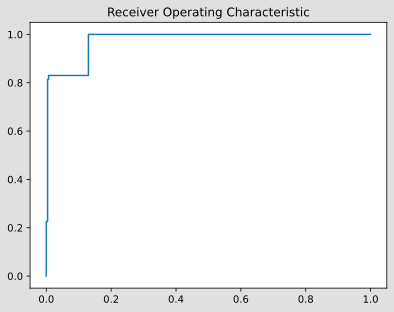

In [32]:
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr)

In [33]:
print(f"Model structure: {nn_model}\n\n")

for name, param in nn_model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Linear(in_features=7, out_features=2, bias=True)
)


Layer: linear_relu_stack.weight | Size: torch.Size([2, 7]) | Values : tensor([[-0.6882,  0.0205,  0.1242, -0.4053,  0.5267,  0.2088,  0.2297],
        [ 0.5807,  0.0220, -0.6780,  0.4409, -0.7081, -0.5792,  0.2096]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.bias | Size: torch.Size([2]) | Values : tensor([ 1.0930, -1.0094], grad_fn=<SliceBackward0>) 



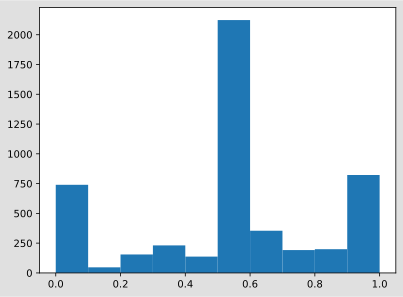

In [45]:
plt.hist(X[:,-2]);

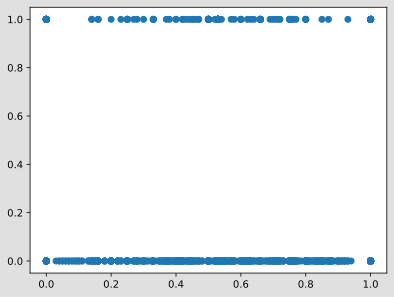

In [47]:
plt.scatter(X[:,-2],y)